## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## Importing Data and Preprocess

In [2]:
data_path = "C:/Users/bakel/OneDrive/Υπολογιστής/Projects/NBA" #file path
os.chdir(data_path) #set to working directory

In [ ]:
#url to download the datasets: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games_details.csv

In [3]:
df = pd.read_csv('games.csv') # file with all NBA games from 2004 to 2022
df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST']) #setting date to datetime type

In [ ]:
df_details = pd.read_csv('games_details.csv', low_memory = False) # dataframe with individual statistics for each player
df_details.drop(['NICKNAME', 'START_POSITION', 'COMMENT'], inplace = True, axis = 1)

df_details.isna().sum()
df_details.dropna(inplace = True, axis = 0) #drop collumns with NaN
df_details['MINS'] = '' #creating empty collumn

#changing mins from object to float value
for i, minutes in enumerate(df_details['MIN']):
    minutes = minutes.split(':')
    minutes = ".".join(minutes)
    minutes = float(minutes)
    df_details.loc[i, 'MINS'] = minutes
    df_details['MINS'] = pd.to_numeric(df_details['MINS'])
    
df_details.to_csv('players_stats.csv', index=False) #saving dataframe to csv

In [7]:
players_stats = pd.read_csv('players_stats.csv') #df with individual player stats after pre-processing

In [10]:
ranking = pd.read_csv('ranking.csv', header = 0) #team ranking dataframe
ranks = ranking.drop(['LEAGUE_ID', 'SEASON_ID', 'CONFERENCE','RETURNTOPLAY'], axis = 1)

games = pd.read_csv('games.csv') # dataframe with all games

dates = games[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'GAME_DATE_EST']] #get game dates

players_stats = pd.merge(players_stats, dates, how = 'left', left_on = 'GAME_ID', right_on = 'GAME_ID') # merge individual stats with game dates

In [11]:
players_stats.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,MIN,FGM,FGA,FG_PCT,...,BLK,TO,PF,PTS,PLUS_MINUS,MINS,VS_TEAMS,HOME_TEAM_ID,VISITOR_TEAM_ID,GAME_DATE_EST
0,22101005.0,1.610613e+09,MIN,Minnesota,1630162.0,Anthony Edwards,36:22,4.0,10.0,0.400,...,1.0,1.0,1.0,15.0,5.0,36.22,1.610613e+09,1610612748,1610612750,2022-03-12
1,22101005.0,1.610613e+09,MIN,Minnesota,1630183.0,Jaden McDaniels,23:54,6.0,8.0,0.750,...,2.0,2.0,6.0,14.0,10.0,23.54,1.610613e+09,1610612748,1610612750,2022-03-12
2,22101005.0,1.610613e+09,MIN,Minnesota,1626157.0,Karl-Anthony Towns,25:17,4.0,9.0,0.444,...,0.0,3.0,4.0,15.0,14.0,25.17,1.610613e+09,1610612748,1610612750,2022-03-12
3,22101005.0,1.610613e+09,MIN,Minnesota,1627736.0,Malik Beasley,30:52,4.0,9.0,0.444,...,0.0,1.0,4.0,12.0,20.0,30.52,1.610613e+09,1610612748,1610612750,2022-03-12
4,22101005.0,1.610613e+09,MIN,Minnesota,1626156.0,D'Angelo Russell,33:46,3.0,13.0,0.231,...,0.0,5.0,0.0,14.0,17.0,33.46,1.610613e+09,1610612748,1610612750,2022-03-12


In [ ]:
# In order to add the ranking of the opposing team for each individual player we need to find whether
# the HOME_TEAM_ID or _VISITOR_TEAM_ID is the same with TEAM_ID collumn
# the following code does that and adds NaN value to the collumn that is not required anymore

for i, team in enumerate(players_stats['TEAM_ID']):
    if team == players_stats.loc[i, 'HOME_TEAM_ID']:
        players_stats.loc[i, 'HOME_TEAM_ID'] = np.NaN
    elif team == players_stats.loc[i, 'VISITOR_TEAM_ID']:
        players_stats.loc[i, 'VISITOR_TEAM_ID'] = np.NaN

In [ ]:
# So just drop NaN values from the two collumns and then
# concat these two collumns in a new dataframe called away_teams
# the new dataframes contains the opposing teams
home_team = players_stats['HOME_TEAM_ID'].dropna(axis = 0)  

visitor_team = players_stats['VISITOR_TEAM_ID'].dropna(axis = 0)
  
away_teams = np.concatenate((home_team, visitor_team), axis = 0)

away_teams = pd.DataFrame(away_teams, columns = ['VS_TEAMS'])
        
players_stats['VS_TEAMS'] = away_teams 

In [ ]:
players_stats.drop(['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], axis = 1, inplace = True) # Drop the unnecessary collumns    
              

players_stats = pd.merge(players_stats, ranks, how = 'left', left_on = ['GAME_DATE_EST', 'VS_TEAMS'],
                         right_on = ['STANDINGSDATE', 'TEAM_ID']) # merge with the rankings dataframe



players_stats.drop(['G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD', 'TEAM_ID_y', 'STANDINGSDATE', 'MIN', 'TEAM_ID_x',
                'PLAYER_ID', 'TEAM_CITY', 'TEAM_ID_x'], axis = 1, inplace = True) # Drop unnecessary collumns again

In [ ]:
final_df = players_stats.drop(['GAME_ID', 'TEAM_ABBREVIATION', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                               'VS_TEAMS'], axis = 1) # final df after pre-process

final_df.isna().sum() # check for NaN values

final_df.dropna(inplace = True, axis = 0) # drop NaN values

final_df = final_df[['PLAYER_NAME', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PTS', 'MINS', 'W_PCT', 'GAME_DATE_EST', 'TEAM', 'PLUS_MINUS']] # re-order collumns order

final_df.to_csv('final_df.csv') # save df to csv file

In [3]:
# Load saved pre-processed dataframe

final_df = pd.read_csv('final_df.csv')
final_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [4]:
final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST']) # converting GAME_DATE_EST to datetime

In [5]:
final_df = final_df[['PLAYER_NAME', 'GAME_DATE_EST', 'TEAM', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PTS', 'MINS', 'W_PCT', 'PLUS_MINUS']] # re-order collumns order

for i, col in enumerate(final_df.iloc[:, 3:]):
    final_df.drop(final_df[final_df[col] < 0].index, inplace = True)

In [6]:
print(final_df.shape)

print(final_df.dtypes)

(211212, 24)
PLAYER_NAME              object
GAME_DATE_EST    datetime64[ns]
TEAM                     object
FGM                     float64
FGA                     float64
FG_PCT                  float64
FG3M                    float64
FG3A                    float64
FG3_PCT                 float64
FTM                     float64
FTA                     float64
FT_PCT                  float64
OREB                    float64
DREB                    float64
REB                     float64
AST                     float64
STL                     float64
BLK                     float64
TO                      float64
PF                      float64
PTS                     float64
MINS                    float64
W_PCT                   float64
PLUS_MINUS              float64
dtype: object


In [53]:
final_df.head()

,PLAYER_NAME,GAME_DATE_EST,TEAM,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,REB,AST,STL,BLK,TO,PF,PTS,MINS,W_PCT,PLUS_MINUS
0,Anthony Edwards,2022-03-12,Miami,4.0,10.0,0.400,3.0,8.0,0.375,4.0,...,8.0,5.0,3.0,1.0,1.0,1.0,15.0,36.22,0.652,5.0
1,Jaden McDaniels,2022-03-12,Miami,6.0,8.0,0.750,1.0,3.0,0.333,1.0,...,6.0,0.0,0.0,2.0,2.0,6.0,14.0,23.54,0.652,10.0
2,Karl-Anthony Towns,2022-03-12,Miami,4.0,9.0,0.444,1.0,3.0,0.333,6.0,...,10.0,0.0,0.0,0.0,3.0,4.0,15.0,25.17,0.652,14.0
3,Malik Beasley,2022-03-12,Miami,4.0,9.0,0.444,4.0,9.0,0.444,0.0,...,3.0,1.0,1.0,0.0,1.0,4.0,12.0,30.52,0.652,20.0
4,D'Angelo Russell,2022-03-12,Miami,3.0,13.0,0.231,1.0,6.0,0.167,7.0,...,6.0,9.0,1.0,0.0,5.0,0.0,14.0,33.46,0.652,17.0


## Seqeunce creation

In [7]:
# So now we need to create sequences in order to train the RNN model
# First we need to groupby PLAYER_NAME

grouping = final_df.groupby(['PLAYER_NAME'])

In [8]:
#Sequences creation

# Create empty lists
dataX = []
dataY = []

validX = []
validY = []

testX = []
testY = []

look_back = 10 # number of games used in order to predict the perfomance of the next game


for j, player in enumerate(grouping):
    temp = pd.DataFrame(player[1], columns = final_df.columns) #create a temp dataframe for each player during iteration
    
    '''
    As an extra feature we want to add the days that player had to rest, before playing the next game
    The following code does that
    '''
    temp = temp.sort_values(by="GAME_DATE_EST") # sort values by date
    temp['REST'] = (temp.GAME_DATE_EST.diff()) # get the difference in days between current row and previous row
    temp['REST'] = temp['REST'].dt.days # convert datetime object to numeric
    temp.dropna(axis = 0, inplace = True) # drop NaN rows (first game got no previous game)
    
    temp = temp[temp['REST'] < 10] # keep rows with REST days below 10, above 10 most probably
                                   # is difference between 2 games of different season
    
    temp.drop(['PLAYER_NAME', 'GAME_DATE_EST', 'TEAM'], axis = 1, inplace = True)
    
    temp['future_PLUS_MINUS'] = temp['PLUS_MINUS'].shift(-1) # shift plus_minus one row
                                                             # so target value will be the next game's perfomance
    
    temp.dropna(axis = 1, inplace = True) # drop possible rows with NaN
                                          
        
    temp.drop(['PLUS_MINUS'], axis = 1, inplace = True)      
    
    
    
    if temp.shape[0] > 10: # to avoid out of index errors
        '''
        last_20pct = sorted(temp.index.values)[-int(0.20*len(temp.index.values))] # get the index of last 20% of data
        
        df_train = temp[(temp.index < last_20pct)]  # training df is the first 80% of data

        df_rest = temp[(temp.index >= last_20pct)] # keep 20% of data and split it between test and validation df, 10% each
     
        half_df = sorted(df_rest.index.values)[-int(0.50*len(df_rest.index.values))]  # split in half

        df_valid = df_rest[(df_rest.index < half_df)] # keep half for validation set
        df_test = df_rest[(df_rest.index >= half_df)] # keep final half for testing
        '''
        minmax_scaler = MinMaxScaler(feature_range = (0, 1))

        temp_values = minmax_scaler.fit_transform(temp.iloc[:, :21])
        
        minmax_scaler_pts = MinMaxScaler(feature_range = (0, 1))
        
        target = minmax_scaler_pts.fit_transform(temp.iloc[:, -1].values.reshape(-1, 1))
        
        for i in range(len(temp) - look_back):
                window_size_x = temp_values[i:(i + look_back)]
                dataX.append(window_size_x)
                dataY.append(target[i + look_back])
        '''
        #print(temp.shape)
        if(temp.shape[0] > 10):
            
            minmax_scaler = MinMaxScaler(feature_range = (0, 1))

            final_df.iloc[:, 3:] = minmax_scaler.fit_transform(final_df.iloc[:, 3:])
            
            values = df_train.iloc[:, :21]
            
            for i in range(len(df_train) - look_back):
                window_size_x = values[i:(i + look_back)]
                dataX.append(window_size_x)
                dataY.append(target_train[i + look_back])
                
        if(df_valid.shape[0] > 10):
            
            target_valid = df_valid.iloc[:, -1].values.reshape(-1, 1)
            
            values_valid = df_valid.iloc[:, :21]
            for i in range(len(df_valid) - look_back):
                window_size_x = values_valid[i:(i + look_back)]
                validX.append(window_size_x)
                validY.append(target_valid[i + look_back])
                
        if(df_test.shape[0] > 10):
            
            target_test = df_test.iloc[:, -1].values.reshape(-1, 1)
            
            values_test = df_test.iloc[:, :21]
            
            for i in range(len(df_test) - look_back):
                window_size_x = values_test[i:(i + look_back)]
                testX.append(window_size_x)
                testY.append(target_test[i + look_back])
        '''

In [10]:
# Final arrays containing all the sequences and the target values
dataX = np.array(dataX)
dataY = np.array(dataY)
print(dataX.shape)
print(dataY.shape)

(161964, 10, 21)
(161964, 1)


In [351]:
# Now we need to shuffle the training data for better to avoid any biases
# We merge both training data and target value into a single list
# Then we shuffle the list so every sequence will keep its corresponding target value
all_data = []

all_data.append([dataX, dataY])

random.shuffle(all_data)

In [352]:
# Finally we create again numpy arrays containing the training data and the target values
X = []
Y = []

for dataX, dataY in all_data: # going over our new sequential data
    X.append(dataX) # X is the sequences
    Y.append(dataY) # y is the targets/labels (buys vs sell/notbuy)

X = np.array(X)
Y = np.array(Y)

In [11]:
# We split the data, keeping 80% for training, 10% for validation and 10% for testing

last_20pct = math.ceil((dataX.shape[0]) * 0.8) # getting the  80% of data

last_10pct = math.ceil((dataY.shape[0]) * 0.9) # getting the 90% of data

trainX = dataX[:last_20pct, :, :] # trainX will contain all sequences up to 80% of data
trainY = dataY[:last_20pct]

validX = dataX[last_20pct: last_10pct, :, :] # validX will contain all sequences among 80% and 90% of data
validY = dataY[last_20pct: last_10pct]

testX = dataX[last_10pct:, :, :] # testX will contain the last 10% of data
testY = dataY[last_10pct:]

In [12]:
#Confirm shape of arrays

print(trainX.shape)
print(trainY.shape)

print(validX.shape)
print(validY.shape)

print(testX.shape)
print(testY.shape)

(129572, 10, 21)
(129572, 1)
(16196, 10, 21)
(16196, 1)
(16196, 10, 21)
(16196, 1)


## Creating RNN model

In [13]:
# Importing necessary libraries

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.layers import LSTM

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # check if there is GPU

model = Sequential()
model.add(LSTM(units = 64, activation = 'relu', dropout = 0.2, recurrent_dropout = 0.2, return_sequences= True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(BatchNormalization())
model.add(LSTM(units = 256, dropout  =0.2, recurrent_dropout = 0.2, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(1))
model.summary()

Num GPUs Available:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            22016     
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 352,257
Trainable p

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD


opt = SGD(learning_rate=0.0001) #optimizer
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics= ['mse']) # metrics used

checkpoint_path = 'C:/Users/bakel/OneDrive/Υπολογιστής/NBA/final_model2.hdf5' # path to save trained model

#save checkpoints while training
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1,
                             save_best_only = True,
                             mode='min')
callbacks = [checkpoint]

# Training the model
history = model.fit(trainX, trainY, batch_size = 128, epochs = 20, verbose=1, shuffle= True,
                    validation_data=(validX, validY), callbacks= callbacks)

Epoch 1/20
1013/1013 [==============================] - ETA: 0s - loss: 0.5862 - mse: 0.5862
Epoch 1: val_loss improved from inf to 0.27027, saving model to C:/Users/bakel/OneDrive/Υπολογιστής/NBA\final_model2.hdf5
1013/1013 [==============================] - 105s 101ms/step - loss: 0.5862 - mse: 0.5862 - val_loss: 0.2703 - val_mse: 0.2703
Epoch 2/20
1013/1013 [==============================] - ETA: 0s - loss: 0.3169 - mse: 0.3169
Epoch 2: val_loss improved from 0.27027 to 0.20724, saving model to C:/Users/bakel/OneDrive/Υπολογιστής/NBA\final_model2.hdf5
1013/1013 [==============================] - 104s 102ms/step - loss: 0.3169 - mse: 0.3169 - val_loss: 0.2072 - val_mse: 0.2072
Epoch 3/20
1013/1013 [==============================] - ETA: 0s - loss: 0.2522 - mse: 0.2522
Epoch 3: val_loss improved from 0.20724 to 0.16897, saving model to C:/Users/bakel/OneDrive/Υπολογιστής/NBA\final_model2.hdf5
1013/1013 [==============================] - 105s 104ms/step - loss: 0.2522 - mse: 0.2522 - v

In [14]:
#Load saved model
from keras.models import load_model

model = load_model('final_model2.hdf5')

In [15]:
# Check the loaded model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            22016     
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               328704    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 352,257
Trainable params: 351,617
Non-trai

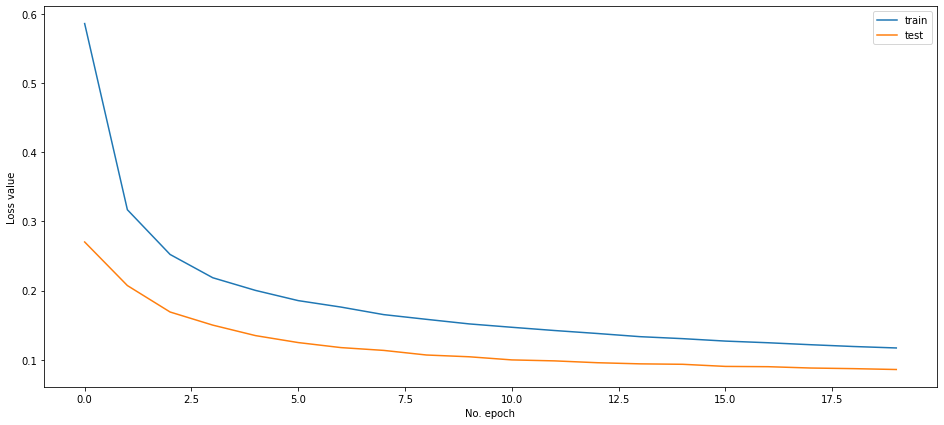

In [31]:
#plot training and validation accuracy - loss

plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend()
#plt.savefig('Training - Test loss.png')
plt.show()

## Testing the model

In [16]:
# In order to test the model we will create sequences based on a single player games
# For this demonstration Dirk Nowitzki was chosen
Dirk = final_df[final_df['PLAYER_NAME'] == 'Dirk Nowitzki']

Dirk.head()

,PLAYER_NAME,GAME_DATE_EST,TEAM,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,REB,AST,STL,BLK,TO,PF,PTS,MINS,W_PCT,PLUS_MINUS
71570,Dirk Nowitzki,2009-05-11,L.A. Lakers,14.0,25.0,0.560,0.0,0.0,0.0,16.0,...,13.0,3.0,2.0,1.0,4.0,1.0,44.0,8.51,0.793,12.0
71648,Dirk Nowitzki,2009-05-09,Indiana,9.0,19.0,0.474,2.0,5.0,0.4,13.0,...,16.0,2.0,0.0,2.0,1.0,2.0,33.0,23.35,0.439,3.0
72097,Dirk Nowitzki,2009-04-28,Indiana,11.0,17.0,0.647,1.0,1.0,1.0,8.0,...,9.0,3.0,1.0,0.0,2.0,2.0,31.0,10.40,0.439,11.0
72323,Dirk Nowitzki,2009-04-25,New Orleans,4.0,9.0,0.444,0.0,0.0,0.0,4.0,...,13.0,1.0,1.0,1.0,3.0,2.0,12.0,3.11,0.598,2.0
72450,Dirk Nowitzki,2009-04-23,Orlando,8.0,12.0,0.667,0.0,1.0,0.0,4.0,...,7.0,2.0,0.0,1.0,1.0,1.0,20.0,15.28,0.720,29.0


In [17]:
Dirk = Dirk.sort_values(by = 'GAME_DATE_EST')
Dirk['REST'] = (Dirk.GAME_DATE_EST.diff())
Dirk['REST'] = Dirk['REST'].dt.days
Dirk.dropna(axis = 0, inplace = True)

Dirk = Dirk[Dirk['REST'] < 10]

In [18]:
Dirk = Dirk[['PLAYER_NAME', 'GAME_DATE_EST', 'TEAM', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF',
       'PTS', 'MINS', 'W_PCT', 'REST', 'PLUS_MINUS']] # re-order collumns order

In [19]:
Dirk.shape

(608, 25)

In [22]:
Dirk.drop(['PLAYER_NAME', 'GAME_DATE_EST', 'TEAM'], axis = 1, inplace = True)
    
Dirk['future_PLUS_MINUS'] = Dirk['PLUS_MINUS'].shift(-1) # shift plus_minus one row 
    
Dirk.dropna(axis = 0, inplace = True) # drop possible rows with NaN
                                          # so target value will be next game's perfomance
        
Dirk.drop(['PLUS_MINUS'], axis = 1, inplace = True)      

In [23]:
Dirk_values = minmax_scaler.fit_transform(Dirk.iloc[:, :21])

In [24]:
Dirk_target = minmax_scaler_pts.fit_transform(Dirk.iloc[:, -1].values.reshape(-1, 1))

In [25]:
Dirk_seq = []
Dirk_target_seq = []

for i in range(len(Dirk) - look_back):  
    window_size_x = Dirk_values[i:(i + look_back)]
    Dirk_seq.append(window_size_x)
    Dirk_target_seq.append(Dirk_target[i + look_back])
    
Dirk_seq = np.array(Dirk_seq)
Dirk_target_seq = np.array(Dirk_target_seq)

In [26]:
Dirk_seq.shape

(597, 10, 21)

In [78]:
sample_test = Dirk_seq[100:301, :]

sample_actual_pts = Dirk_target_seq[100:301]

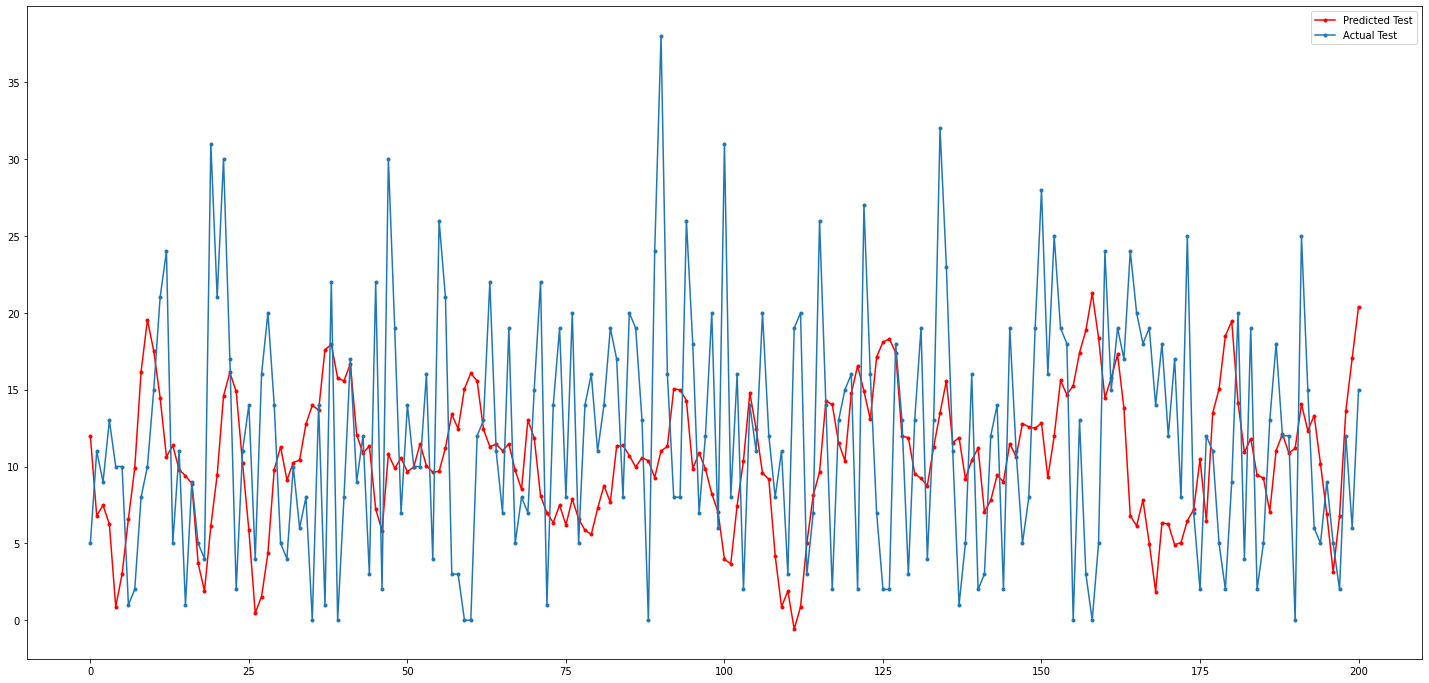

In [79]:
# Testing on unseen samples
import matplotlib.pyplot as plt
predict_pts = model.predict(sample_test)

predict_pts = minmax_scaler_pts.inverse_transform(predict_pts.reshape(-1, 1))
sample_actual_pts = minmax_scaler_pts.inverse_transform(sample_actual_pts.reshape(-1, 1))

plt.figure(figsize=(25,12))

plt.plot(predict_pts, 'r', marker='.', label='Predicted Test')

plt.plot(sample_actual_pts, marker='.', label='Actual Test')

plt.legend()
#plt.savefig('Test_perfomance_prediction.png')
plt.show()